# Plotting results
***

## Imports

In [1]:
# Standard library
import ast
import json

# Fundamental data libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Statistics
from scipy.stats import binomtest

## Results paths

In [2]:
results_paths = {
    "o3-mini-low":     "results/o3-mini-low_results.csv",
    "o3-mini-medium":  "results/o3-mini-medium_results.csv",
    "o3-mini-high":    "results/o3-mini-high_results.csv",
    "gpt-4o":          "results/gpt-4o_results.csv",
    "gpt-4o-tags":     "results/gpt-4o-tags_results.csv",
}

## Load results

In [3]:
def read_jsonl(path):
    """Simple JSONL reader: returns a list of dicts."""
    with open(path, 'r') as f:
        return [json.loads(line) for line in f]

# Load questions
all_questions = read_jsonl("questions/chemiq.jsonl") + read_jsonl("questions/additional_smiles_to_iupac.jsonl")
question_dict = {q["uuid"]: q for q in all_questions}

# Load results for each model
# - Cases where model failed to give a response to a question contained in the question set are counted as failure
data_records = []
for model, file_path in results_paths.items():
    df_tmp = pd.read_csv(file_path)
    
    # for gpt-4o variants, mirror completion_tokens into reasoning_tokens
    if model in ["gpt-4o", "gpt-4o-tags"]:
        df_tmp["reasoning_tokens"] = df_tmp["completion_tokens"]
    
    # ensure sub_category is never null
    df_tmp["sub_category"] = df_tmp["sub_category"].fillna("")
    
    # convert to list of dicts and tag each with its model
    records = df_tmp.to_dict(orient="records")
    for rec in records:
        rec["model"] = model
    
    # If model did not give a response, add this as failed result
    answered_uuids = {rec["uuid"] for rec in records}
    for uuid, q in question_dict.items():
        if uuid not in answered_uuids:
            records.append({
                "model":             model,
                "uuid":              uuid,
                "question_category": q["question_category"],
                "sub_category":      q["sub_category"] or "",
                "ChemIQ":            q["ChemIQ"],
                "success":           False,
                "expected_answer":   q["answer"],
                "model_answer":      np.nan,
                "opsin_smiles":      np.nan,
                "completion_tokens": np.nan,
                "reasoning_tokens":  np.nan,
            })
    
    data_records.extend(records)

df = pd.DataFrame(data_records)

# Plotting
***

## Colours

In [4]:
pastel_palette = {
    "pastel_salmon":   "#FFB5A8",
    "pastel_teal":     "#AEC6CF",
    "pastel_orange":   "#FFC067",
    "pastel_yellow":   "#FDFD96",
}

models = ["gpt-4o", "o3-mini-low", "o3-mini-medium", "o3-mini-high"]
reasoning_models = ["o3-mini-low", "o3-mini-medium", "o3-mini-high"]

model_colors = {
    "gpt-4o":        pastel_palette["pastel_teal"],
    "o3-mini-low":   pastel_palette["pastel_yellow"],
    "o3-mini-medium":pastel_palette["pastel_orange"],
    "o3-mini-high":  pastel_palette["pastel_salmon"],
}

token_axis_color = "blue"
darken_color = lambda col, factor=0.7: tuple(max(min(c * factor, 1), 0) for c in mcolors.to_rgb(col))
lighten = lambda col, amt=0.9: tuple(np.array(mcolors.to_rgb(col)) + (1 - np.array(mcolors.to_rgb(col))) * amt)

## Overall success rate + tokens

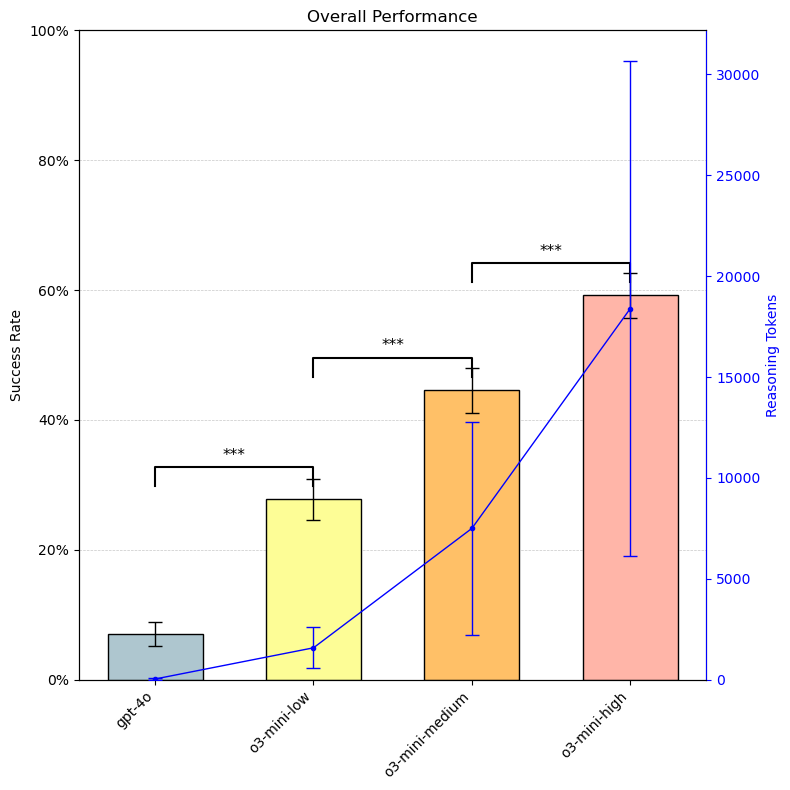

Success rate by model:
 - gpt-4o: 7.0%
 - o3-mini-low: 27.8%
 - o3-mini-medium: 44.6%
 - o3-mini-high: 59.2%


In [5]:
# Filter the dataframe to only include ChemIQ questions
df_subset = df[((df["question_category"] != "smiles_to_iupac") | ((df["question_category"] == "smiles_to_iupac") & (df["sub_category"].isin(["zinc_random","zinc_canonical"]))))]

# Total unique questions
total_questions = df_subset["uuid"].nunique()

# Model perfomance
performance = (df_subset.groupby("model")["success"].sum().reindex(models)/ total_questions)
avg_tokens = (df_subset.groupby("model")["reasoning_tokens"].mean().reindex(models))
token_std = (df_subset.groupby("model")["reasoning_tokens"].std().reindex(models))

# McNemar statistical test
mcnemar_adjacent = {}
for i in range(len(models) - 1):
    m1, m2 = models[i], models[i + 1]
    pair = (
        df_subset[df_subset["model"].isin([m1, m2])]
        .pivot(index="uuid", columns="model", values="success")
        .fillna(0)
        .astype(int)
    )
    b = ((pair[m1] == 1) & (pair[m2] == 0)).sum()       # successes unique to m1
    c = ((pair[m1] == 0) & (pair[m2] == 1)).sum()       # successes unique to m2
    n_disc = b + c
    p_val = (
        binomtest(b, n=n_disc, p=0.5, alternative="less").pvalue
        if n_disc > 0 else None
    )
    mcnemar_adjacent[(m1, m2)] = p_val


# Plot
fig, ax1 = plt.subplots(figsize=(8, 8))
x = np.arange(len(models))

# Success rates
bars = ax1.bar(
    x,
    performance.values,
    color=[model_colors[m] for m in models],
    edgecolor="black",
    linewidth=1,
    width=0.6,
    zorder=3
)
ax1.set_ylabel("Success Rate")
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha="right")
ax1.set_ylim(0, 1.0)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.7, zorder=0)

# Vertical 95% Confidence intervals
performance_err = np.sqrt(performance * (1 - performance) / total_questions)
ax1.errorbar(
    x,
    performance.values,
    yerr=performance_err.values * 1.96,
    fmt="none",
    capsize=5,
    ecolor="black",
    elinewidth=1,
    zorder=4
)

# Plot significance levels 
def annotate_significance(ax, x1, x2, base, text, height=0.03, offset=0.02):
    y = base + offset
    ax.plot([x1, x1, x2, x2], [y, y+height, y+height, y], lw=1.5, c="black")
    ax.text((x1 + x2) / 2, y + height + offset / 3, text,
            ha="center", va="bottom", fontsize=11)

for i in range(len(models) - 1):
    m1, m2 = models[i], models[i + 1]
    p = mcnemar_adjacent[(m1, m2)]
    if p is not None and p < 0.05:
        stars = "***" if p < 0.001 else ("**" if p < 0.01 else "*")
        base = max(performance[m1], performance[m2])
        annotate_significance(ax1, x[i], x[i + 1], base, stars)

# Reasoning tokens used
ax2 = ax1.twinx()
ax2.set_ylabel("Reasoning Tokens", color=token_axis_color)
ax2.errorbar(
    x,
    avg_tokens.values,
    yerr=token_std.values,
    marker=".",
    linestyle="-",
    linewidth=1,
    markersize=6,
    capsize=5,
    color=token_axis_color,
    alpha=1,
    zorder=5
)

ax2.tick_params(axis="y", colors=token_axis_color)
ax2.spines["right"].set_color(token_axis_color)
ax2.set_ylim(bottom=0)
plt.title("Overall Performance")
plt.tight_layout()

plt.savefig("figures/all_question_bar.pdf", format="pdf", bbox_inches="tight")
plt.show()

print("Success rate by model:")
for m, v in performance.items():
    print(f" - {m}: {v * 100:.1f}%")

## Radial plot

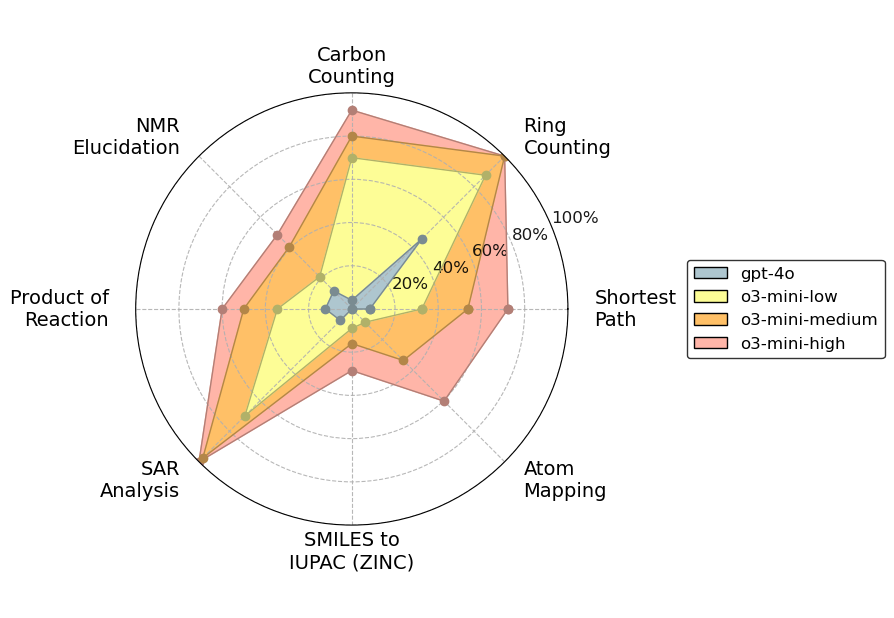

In [6]:
model_order = ['gpt-4o', 'o3-mini-low', 'o3-mini-medium', 'o3-mini-high']

question_order = ["shortest_path", 
                  "counting_ring", 
                  "counting_carbon", 
                  "nmr_elucidation",
                  "reaction", 
                  "sar", 
                  "smiles_to_iupac", 
                  "atom_mapping"
]

question_labels = {
    "counting_carbon": "Carbon\nCounting",
    "counting_ring":   "Ring\nCounting",
    "sar":             "SAR\nAnalysis",
    "shortest_path":   "Shortest\nPath",
    "atom_mapping":    "Atom\nMapping",
    "smiles_to_iupac": "SMILES to\nIUPAC (ZINC)",
    "reaction":        "Product of\nReaction",
    "nmr_elucidation": "NMR\nElucidation"
}

tick_fontsize  = 12
label_fontsize = 14

# Making radial plot
fig = plt.figure(figsize=(9, 7))
gs  = fig.add_gridspec(1, 2, width_ratios=[4, 1])
ax_polar  = fig.add_subplot(gs[0, 0], projection='polar')
ax_legend = fig.add_subplot(gs[0, 1])

# Draw each polygon
for z, model in enumerate(reversed(model_order), start=2):
    df_m = df[df["model"] == model]

    # Per-question success rate
    success_rates = []
    for q in question_order:
        if q == "smiles_to_iupac":
            mask = (
                (df["question_category"] == "smiles_to_iupac") &
                (df["sub_category"].isin(["zinc_canonical", "zinc_random"]))
            )
            denom = df[mask]["uuid"].nunique()
            num   = df_m[mask.loc[df_m.index]]["success"].sum()
        
        else:
            mask  = (df["question_category"] == q)
            denom = df[mask]["uuid"].nunique()
            num   = df_m[mask.loc[df_m.index]]["success"].sum()

        rate = num / denom if denom else 0.0
        success_rates.append(rate)

    # Close the loop for radar plotting
    values  = np.array(success_rates + [success_rates[0]])
    angles  = np.linspace(0, 2 * np.pi, len(success_rates), endpoint=False)
    angles  = np.concatenate([angles, [angles[0]]])

    base_color    = model_colors.get(model, "grey")
    outline_color = darken_color(base_color, factor=0.7)

    # Draw filled polygon and outline
    ax_polar.fill(angles, values, color=base_color, alpha=1)
    ax_polar.plot(angles, values, marker='o', linewidth=1, color=outline_color)

# Labels for each question category
N_labels = len(question_order)
label_angles = np.linspace(0, 2 * np.pi, N_labels, endpoint=False)
ax_polar.set_xticks(label_angles)
ax_polar.set_xticklabels([])           # hide default labels

offset_radius = ax_polar.get_ylim()[1] * 1.07
for txt, ang in zip(question_order, label_angles):
    lbl   = question_labels.get(txt, txt)
    deg   = np.degrees(ang)
    ha    = 'right' if (90 < deg < 270) else ('center' if deg in [90, 270] else 'left')
    ax_polar.text(ang, offset_radius, lbl, ha=ha, va='center',
                  fontsize=label_fontsize)

# labels and grid
ax_polar.set_ylim(0, 1)
ax_polar.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax_polar.set_yticklabels(['20%', '40%', '60%', '80%', '100%'], fontsize=tick_fontsize)

for gl in ax_polar.get_xgridlines() + ax_polar.get_ygridlines():
    gl.set_zorder(100)
    gl.set_linestyle("--")
    gl.set_alpha(0.9)

for lbl in ax_polar.get_yticklabels():
    lbl.set_zorder(200)
    lbl.set_alpha(0.9)

# Legend
legend_handles = [
    mpatches.Patch(facecolor=model_colors.get(m, "grey"), edgecolor="black", label=m)
    for m in model_order
]
ax_legend.axis('off')
ax_legend.legend(handles=legend_handles, loc='center',
                 fontsize=tick_fontsize, frameon=True,
                 edgecolor="black")

# Save plot
plt.tight_layout()
plt.savefig("figures/radial_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Shortest path and atom mapping

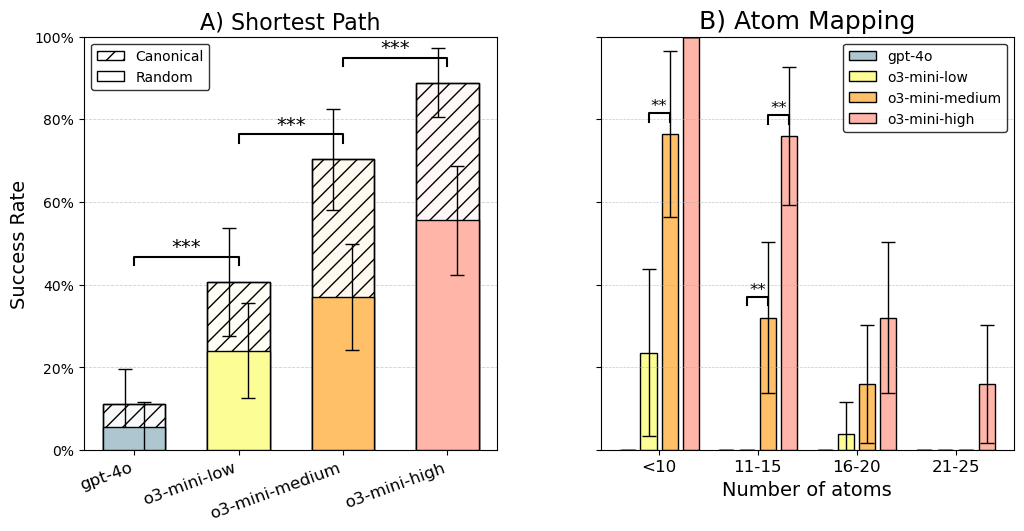

In [7]:
atom_mapping_df = df[df["question_category"] == "atom_mapping"].copy()
# convert expected_answer (string list) to actual list length
atom_mapping_df["n_atoms"] = atom_mapping_df["expected_answer"].apply(
    lambda x: len(x) if isinstance(x, (list, tuple)) else len(ast.literal_eval(x))
)

def to_bucket(n):
    if n <= 10:   return "<10"
    if n <= 15:   return "11-15"
    if n <= 20:   return "16-20"
    if n <= 25:   return "21-25"
    return None

atom_mapping_df["bar_name"] = atom_mapping_df["n_atoms"].apply(to_bucket)
atom_mapping_df = atom_mapping_df[atom_mapping_df["bar_name"].notnull()]

# Plot
fig, axs = plt.subplots(
    1, 2,
    figsize=(12, 6),
    sharey=True,
    gridspec_kw={"wspace": 0.25}
)

# LEFT: Shortest path (Canonical vs random)
left_ax = axs[0]
sp_sub = df[df["question_category"] == "shortest_path"]
sp_can = sp_sub[sp_sub["sub_category"] == "canonical"]
sp_rnd = sp_sub[sp_sub["sub_category"] == "random"]

perf_can = sp_can.groupby("model")["success"].mean().reindex(models)
perf_rnd = sp_rnd.groupby("model")["success"].mean().reindex(models)

n_can = sp_can.groupby("model")["success"].count().reindex(models)
n_rnd = sp_rnd.groupby("model")["success"].count().reindex(models)

se_can = np.sqrt(perf_can * (1 - perf_can) / n_can)
se_rnd = np.sqrt(perf_rnd * (1 - perf_rnd) / n_rnd)

x = np.arange(len(models))
width = 0.6
offset = width * 0.15

# grid & baseline
left_ax.set_axisbelow(True)
left_ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6, zorder=0)

# canonical bars (lightened + hatched overlay)
light_cols = [lighten(model_colors[m]) for m in models]
bars_can = left_ax.bar(
    x, perf_can.values,
    width=width, color=light_cols,
    edgecolor="black", linewidth=1,
    label="Canonical", zorder=2
)
for rect in bars_can:                    # hatch overlay
    left_ax.add_patch(
        mpatches.Rectangle(
            (rect.get_x(), rect.get_y()),
            rect.get_width(), rect.get_height(),
            fill=False, hatch="//", edgecolor="black",
            linewidth=1, zorder=3
        )
    )
left_ax.errorbar(
    x - offset, perf_can.values,
    yerr=1.96 * se_can.values,
    fmt="none", ecolor="black", capsize=5, elinewidth=1, zorder=4
)

# random bars
bars_rnd = left_ax.bar(
    x, perf_rnd.values,
    width=width, color=[model_colors[m] for m in models],
    edgecolor="black", linewidth=1,
    label="Random", zorder=5
)
left_ax.errorbar(
    x + offset, perf_rnd.values,
    yerr=1.96 * se_rnd.values,
    fmt="none", ecolor="black", capsize=5, elinewidth=1, zorder=6
)

# significance between adjacent models (McNemar style)
merged_sp = pd.concat([sp_can, sp_rnd])          # both canonical & random
for i in range(len(models) - 1):
    m1, m2 = models[i], models[i + 1]
    d1 = merged_sp[merged_sp["model"] == m1][["uuid", "success"]].rename(columns={"success": "s1"})
    d2 = merged_sp[merged_sp["model"] == m2][["uuid", "success"]].rename(columns={"success": "s2"})
    mrg = d1.merge(d2, on="uuid")
    b = ((mrg.s1 == 1) & (mrg.s2 == 0)).sum()
    c = ((mrg.s1 == 0) & (mrg.s2 == 1)).sum()
    if (b + c) > 0:
        p = binomtest(b, n=b + c, p=0.5, alternative="less").pvalue
        if p < 0.05:
            stars = "***" if p < 0.001 else ("**" if p < 0.01 else "*")
            base  = max(
                perf_can.iloc[i], perf_rnd.iloc[i],
                perf_can.iloc[i + 1], perf_rnd.iloc[i + 1]
            )
            y = base + 0.04
            left_ax.plot(
                [x[i], x[i], x[i + 1], x[i + 1]],
                [y, y + 0.02, y + 0.02, y],
                c="black", linewidth=1.5, zorder=7
            )
            left_ax.text(
                (x[i] + x[i + 1]) / 2, y + 0.02,
                stars, ha="center", va="bottom",
                fontsize=14, zorder=8
            )

# cosmetics & legend
left_ax.set_title("A) Shortest Path", fontsize=16)
left_ax.set_xticks(x)
left_ax.set_xticklabels(models, rotation=20, ha="right", fontsize=12)
left_ax.set_ylim(0, 1.0)
left_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
left_ax.set_ylabel("Success Rate", fontsize=14)

can_patch = mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="Canonical")
rnd_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="Random")
left_ax.legend(handles=[can_patch, rnd_patch],
               fontsize=10, frameon=True, edgecolor="black")

# Right: Atom mapping
right_ax = axs[1]

group_order = ["<10", "11-15", "16-20", "21-25"]
group_x     = np.arange(len(group_order))
group_w     = 0.8
gap         = 0.05
n_models    = len(reasoning_models) + 1     # gpt-4o + 3 minis
bar_w       = (group_w - gap * (n_models - 1)) / n_models

# prepare mean, counts, SEs
perf_df  = (
    atom_mapping_df[atom_mapping_df["sub_category"] == "random"]
    .groupby(["bar_name", "model"])["success"]
    .mean().unstack()
)
count_df = (
    atom_mapping_df[atom_mapping_df["sub_category"] == "random"]
    .groupby(["bar_name", "model"])["success"]
    .count().unstack()
)
err_df   = np.sqrt(perf_df * (1 - perf_df) / count_df) * 1.96   # 95 % CI

# bars with error bars
for i, model in enumerate(["gpt-4o"] + reasoning_models):
    pos = group_x - group_w/2 + i*(bar_w + gap) + bar_w/2
    vals = [perf_df.loc[g, model] for g in group_order]
    errs = [err_df.loc[g, model]  for g in group_order]
    right_ax.bar(
        pos, vals,
        width=bar_w,
        color=model_colors.get(model, "#999999"),
        edgecolor="black", linewidth=1,
        label=model
    )
    right_ax.errorbar(
        pos, vals,
        yerr=errs,
        fmt="none",
        capsize=5, ecolor="black", elinewidth=1
    )

# significance stars inside each group (adjacent models)
for gi, grp in enumerate(group_order):
    df_g = atom_mapping_df[
        (atom_mapping_df["bar_name"] == grp) &
        (atom_mapping_df["sub_category"] == "random")
    ]
    for i in range(len(models) - 1):
        m1, m2 = models[i], models[i + 1]
        d1 = df_g[df_g["model"] == m1][["uuid", "success"]].rename(columns={"success": "s1"})
        d2 = df_g[df_g["model"] == m2][["uuid", "success"]].rename(columns={"success": "s2"})
        mrg = d1.merge(d2, on="uuid")
        b = ((mrg.s1 == 1) & (mrg.s2 == 0)).sum()
        c = ((mrg.s1 == 0) & (mrg.s2 == 1)).sum()
        if (b + c) > 0:
            p = binomtest(b, n=b + c, p=0.5, alternative="less").pvalue
            if p < 0.05:
                stars = "***" if p < 0.001 else ("**" if p < 0.01 else "*")
                base = max(perf_df.loc[grp, m1], perf_df.loc[grp, m2])
                x1 = group_x[gi] - group_w/2 + i*(bar_w + gap) + bar_w/2
                x2 = group_x[gi] - group_w/2 + (i + 1)*(bar_w + gap) + bar_w/2
                y  = base + 0.03
                right_ax.plot([x1, x1, x2, x2],
                              [y, y + 0.02, y + 0.02, y],
                              lw=1.5, c="black")
                right_ax.text((x1 + x2)/2, y + 0.02,
                              stars, ha="center", va="bottom", fontsize=12)

# cosmetics & legend
right_ax.set_xlabel("Number of atoms", fontsize=14)
right_ax.set_xticks(group_x)
right_ax.set_xticklabels(group_order, fontsize=12)
right_ax.set_ylim(0, 1.0)
right_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
right_ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
right_ax.set_title("B) Atom Mapping", fontsize=18)
right_ax.legend(fontsize=10, frameon=True, edgecolor="black", loc="upper right")

for ax in axs:
    ax.set_box_aspect(1)                  # square panels

plt.tight_layout()
plt.savefig("figures/fig_comparison.png", dpi=300)
plt.show()

## SMILES to IUPAC

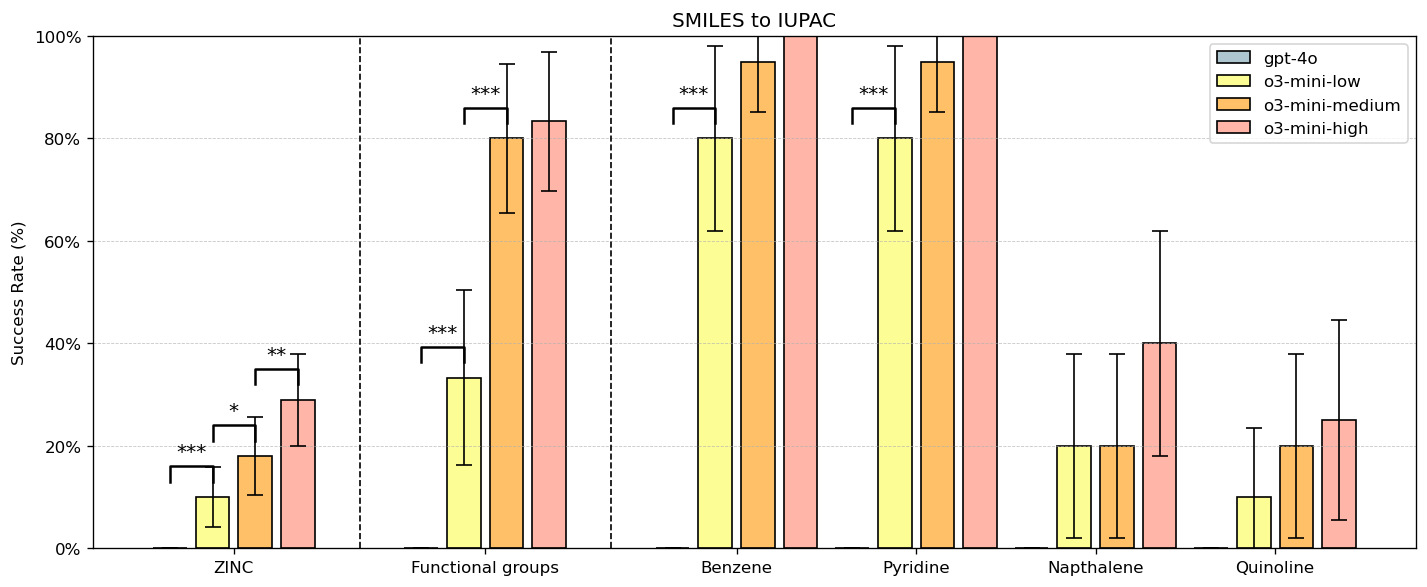

In [8]:
# Define the sub-categories in order.
sub_categories_to_plot = [
    "zinc_canonical", 
    "FG_canonical", 
    "Benzene_canonical",
    "Pyridine_canonical",
    "Napthalene_canonical",
    "Quinoline_canonical"
]

# Define the grouping of sub-categories.
sections = [
    ["zinc_canonical"],
    ["FG_canonical"],
    ["Benzene_canonical", "Pyridine_canonical", "Napthalene_canonical", "Quinoline_canonical"]
]

# Compute x positions for each sub-category.
extra_gap = 0.4  # extra gap between groups
positions = {}
current_pos = 0
for i, section in enumerate(sections):
    for sub in section:
        positions[sub] = current_pos
        current_pos += 1  # standard spacing within a section
    if i < len(sections) - 1:
        current_pos += extra_gap  # extra gap between sections

# Ordered list of tick positions.
group_positions = [positions[sub] for sub in sub_categories_to_plot]

# Define the order of models.
models = ["gpt-4o", "o3-mini-low", "o3-mini-medium", "o3-mini-high"]

# Bar layout parameters within each sub-category group.
group_width = 0.9      # total width allocated for bars in one group
bar_gap = 0.05         # gap between bars for different models within a group
n_models = len(models)
bar_width = (group_width - (n_models - 1) * bar_gap) / n_models

# Create the figure with a higher dpi if needed.
fig, ax = plt.subplots(figsize=(12, 5), dpi=120)

# Dictionary to store bar x positions for later annotation.
bar_positions_dict = {}

# Plot bars for each model.
for j, model in enumerate(models):
    perf_values = []   # mean success for each sub-category
    perf_err = []      # corresponding 95% CI error values
    model_bar_positions = []  # x positions for this model’s bars
    for sub_cat in sub_categories_to_plot:
        base_x = positions[sub_cat]
        # Calculate the x position within the group.
        pos = base_x - group_width/2 + j*(bar_width + bar_gap) + bar_width/2
        model_bar_positions.append(pos)
        bar_positions_dict[(sub_cat, model)] = pos
        
        # Filter the DataFrame for this sub-category and model.
        df_sub = df[(df["sub_category"] == sub_cat) & (df["model"] == model)]
        if not df_sub.empty:
            mean_val = df_sub["success"].mean()
            perf_values.append(mean_val)
            # Compute standard error; if only one sample, set error to 0.
            if len(df_sub) > 1:
                se = df_sub["success"].std() / np.sqrt(len(df_sub))
                ci = 1.96 * se
            else:
                ci = 0
            perf_err.append(ci)
        else:
            perf_values.append(np.nan)
            perf_err.append(0)
    # Plot the bars with vertical error bars using error_kw for consistent styling.
    ax.bar(
        model_bar_positions,
        perf_values,
        width=bar_width,
        color=model_colors.get(model, "#999999"),
        edgecolor='black',
        yerr=perf_err,
        error_kw={'elinewidth': 1, 'ecolor': 'black', 'capsize': 5},
        label=model
    )

# Add dotted vertical lines for group separations.
# Calculate boundaries as the midpoint between the last sub-category of one section and the first of the next.
boundaries = []
for i in range(len(sections) - 1):
    last_cat = sections[i][-1]
    first_cat = sections[i+1][0]
    boundary_x = (positions[last_cat] + positions[first_cat]) / 2
    boundaries.append(boundary_x)

for xb in boundaries:
    ax.axvline(x=xb, linestyle='--', color='black', linewidth=1)

# Set x-axis tick positions and labels.
ax.set_xticks(group_positions)
ax.set_xticklabels(sub_categories_to_plot, rotation=45, ha='right')

# Label the y-axis and format as a percentage.
ax.set_ylabel("Success Rate (%)")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title("SMILES to IUPAC")
ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7, zorder=0)
ax.set_ylim(0, 1)
ax.legend()


new_labels = ["ZINC", "Functional groups", "Benzene", "Pyridine", "Napthalene", "Quinoline"]
ax.set_xticks(group_positions)
ax.set_xticklabels(new_labels, rotation=0, ha='center')

# Helper function to annotate significance with horizontal staples.
def annotate_significance(ax, x1, x2, base, text, height=0.03, offset=0.03, tick_fontsize=12):
    ylim_top = ax.get_ylim()[1]
    desired_y = base + offset
    if desired_y + height <= ylim_top:
        y = desired_y
        ax.plot([x1, x1, x2, x2], [y, y+height, y+height, y], lw=1.5, c='black')
        ax.text((x1+x2)/2, y+height+offset/3, text, ha='center', va='bottom',
                color='black', fontsize=tick_fontsize)
    else:
        y = base - height - offset
        ax.plot([x1, x1, x2, x2], [y, y+height, y+height, y], lw=1.5, c='black')
        ax.text((x1+x2)/2, y - offset/3, text, ha='center', va='top',
                color='black', fontsize=tick_fontsize)

# For each sub-category group, perform McNemar tests between adjacent models and annotate.
test_direction = "less"  # adjust if needed
for sub_cat in sub_categories_to_plot:
    for i in range(len(models)-1):
        model1 = models[i]
        model2 = models[i+1]
        # Retrieve x positions from the stored dictionary.
        x1 = bar_positions_dict.get((sub_cat, model1))
        x2 = bar_positions_dict.get((sub_cat, model2))
        # Filter data for the two models in the current sub-category.
        df_m1 = df[(df["sub_category"] == sub_cat) & (df["model"] == model1)]
        df_m2 = df[(df["sub_category"] == sub_cat) & (df["model"] == model2)]
        if df_m1.empty or df_m2.empty:
            continue  # skip if one model has no data
        
        # Compute mean performance for positioning the annotation.
        mean1 = df_m1["success"].mean()
        mean2 = df_m2["success"].mean()
        base = max(mean1, mean2)
        
        # Merge on 'uuid' to pair observations.
        df_m1_pair = df_m1[["uuid", "success"]].rename(columns={"success": "success1"})
        df_m2_pair = df_m2[["uuid", "success"]].rename(columns={"success": "success2"})
        df_pair = pd.merge(df_m1_pair, df_m2_pair, on="uuid")
        b = ((df_pair["success1"] == 1) & (df_pair["success2"] == 0)).sum()
        c = ((df_pair["success1"] == 0) & (df_pair["success2"] == 1)).sum()
        n_disc = b + c
        if n_disc > 0:
            p_val = binomtest(b, n=n_disc, p=0.5, alternative=test_direction).pvalue
        else:
            p_val = None
        
        # If McNemar's test is significant, annotate with a horizontal staple.
        if p_val is not None and p_val < 0.05:
            if p_val < 0.001:
                sig_text = '***'
            elif p_val < 0.01:
                sig_text = '**'
            else:
                sig_text = '*'
            annotate_significance(ax, x1, x2, base, sig_text, height=0.03, offset=0.03, tick_fontsize=12)

plt.tight_layout()
plt.savefig("figures/smiles_to_iupac_all.pdf", format="pdf", bbox_inches="tight")
plt.show()

## LaTeX tables

In [9]:
# === 2) DEFINE models & TABLE‐SUBCATEGORY SETS ===
DESIRED_models = ["gpt-4o","gpt-4o-tags","o3-mini-low","o3-mini-medium","o3-mini-high"]

QUESTION_SUBCATEGORIES_Table1 = {
    'counting_carbon': [""],
    'counting_ring':   [""],
    'shortest_path':   ['canonical','random'],
    'atom_mapping':    ['semi-canonical','random'],
    'smiles_to_iupac': ['zinc_canonical','zinc_random'],
    'sar':             ['integer','noise'],
    'reaction':        ['synthetic_canonical','synthetic_random'],
    'nmr_elucidation': ['small','zinc'],
}

QUESTION_SUBCATEGORIES_Table2 = {
    'smiles_to_iupac': [
        'FG_canonical','FG_random',
        'Benzene_canonical','Benzene_random',
        'Pyridine_canonical','Pyridine_random',
        'Isoxazole_canonical','Isoxazole_random',
        'Napthalene_canonical','Napthalene_random',
        'Quinoline_canonical','Quinoline_random',
    ],
    'reaction': ['ORD_canonical','ORD_random'],
}

# === 3) TABLE‐GENERATOR FUNCTION ===
def generate_latex_tables(QUESTION_SUBCATEGORIES, df, num_q):
    # a) enforce order on question_category
    df = df.copy()
    df["question_category"] = pd.Categorical(
        df["question_category"],
        categories=list(QUESTION_SUBCATEGORIES.keys()),
        ordered=True
    )

    # b) aggregate successes, counts, mean/std of reasoning_tokens
    agg = (
        df.groupby(["question_category","sub_category","model"], observed=False)
          .agg(
            successes       = ("success","sum"),
            total_responses = ("success","count"),
            mean_tok        = ("reasoning_tokens","mean"),
            std_tok         = ("reasoning_tokens","std")
          )
          .reset_index()
    )

    # c) build the full (cat,subcat,model) index and left‐merge
    full_idx = pd.MultiIndex.from_tuples(
        [
            (qc, sc, m)
            for qc, subcats in QUESTION_SUBCATEGORIES.items()
            for sc in subcats
            for m in DESIRED_models
        ],
        names=["question_category","sub_category","model"]
    )
    df_full = (
        pd.DataFrame(index=full_idx)
          .reset_index()
          .merge(agg, on=["question_category","sub_category","model"], how="left")
          .merge(num_q, on=["question_category","sub_category"],           how="left")
    )

    # d) fill zeros for counts & successes; leave mean/std as NaN
    df_full["successes"]       = df_full["successes"].fillna(0)
    df_full["total_responses"] = df_full["total_responses"].fillna(0)

    # e) compute rates & 95% CIs
    df_full["success_rate"] = df_full["successes"] / df_full["N."]
    df_full["se"] = np.sqrt(df_full["success_rate"] * (1 - df_full["success_rate"]) / df_full["N."])
    df_full["ci_lo"] = (df_full["success_rate"] - 1.96*df_full["se"]).clip(lower=0)
    df_full["ci_hi"] = (df_full["success_rate"] + 1.96*df_full["se"]).clip(upper=1)

    # f) pivot to get metrics by model
    pv = df_full.pivot(
        index=["question_category","sub_category"],
        columns="model",
        values=["success_rate","se","mean_tok","std_tok"]
    )


    # Reindex to be written in order
    desired_index = pd.MultiIndex.from_tuples(
        [
            (qc, sc)
            for qc, subcats in QUESTION_SUBCATEGORIES.items()
            for sc in subcats
        ],
        names=["question_category","sub_category"]
    )
    pv = pv.reindex(desired_index)

    # g) formatting helpers
    def fmt_rate(row, m):
        r = row[("success_rate", m)]
        s = row[("se",          m)]
        if pd.isna(r) or pd.isna(s):
            return ""
        return f"{100*r:4.1f} ± {100*1.96*s:4.1f}"

    def fmt_tok(row, m):
        μ = row[("mean_tok", m)]
        σ = row[("std_tok",  m)]
        if pd.isna(μ) or pd.isna(σ):
            return ""
        return f"{int(round(μ))} ± {int(round(σ))}"

    # h) build string‐tables
    success_df   = pd.DataFrame(index=pv.index)
    reasoning_df = pd.DataFrame(index=pv.index)
    for m in DESIRED_models:
        success_df[m]   = pv.apply(lambda r: fmt_rate(r, m), axis=1)
        reasoning_df[m] = pv.apply(lambda r: fmt_tok(r, m),  axis=1)

    # i) reattach N., flatten categories
    success_df   = success_df.reset_index().merge(num_q, on=["question_category","sub_category"])
    reasoning_df = reasoning_df.reset_index().merge(num_q, on=["question_category","sub_category"])

    def flatten_categories(df):
        out, cur = [], None
        for _, r in df.iterrows():
            qc, sc, n = r["question_category"], r["sub_category"], r["N."]
            label = qc if qc != cur else ""
            prefix = "" if label else "\\hspace{2em}"
            out.append(f"{label}\\\\ {prefix}{sc} (n={n})")
            cur = qc
        df["Question Category"] = out
        return df

    sflat = flatten_categories(success_df.copy())
    rflat = flatten_categories(reasoning_df.copy())

    # j) drop the old cols & reorder
    for tbl in (sflat, rflat):
        tbl.drop(columns=["question_category","sub_category","N."], inplace=True)
        cols = tbl.columns.tolist()
        cols.insert(0, cols.pop(cols.index("Question Category")))
        tbl[:] = tbl[cols]

    # k) render LaTeX
    tex_s = sflat.to_latex(
        index=False, escape=False,
        caption=("Success rate (\\%) by model per subcategory. "
                 "± gives 95\\% confidence interval."),
        label="all_success_data"
    )
    tex_r = rflat.to_latex(
        index=False, escape=False,
        caption=("Reasoning tokens ± std dev by model per subcategory."),
        label="all_reasoning_token_data"
    )

    # l) footnote + replacements
    foot = r"""}
\begin{flushleft}
\item $^c$ Canonical SMILES
\item $^r$ Random SMILES
\end{flushleft}"""
    def insert_footnote(s): 
        parts = s.split("\n")
        return "\n".join(parts[:-2] + [foot] + parts[-2:])

    tex_s = insert_footnote(tex_s)
    tex_r = insert_footnote(tex_r)

    repl = {
      "\\begin{table}": "\\begin{table}[H]",
      "_random":      "$^r$",
      "_canonical":   "$^c$",
      "\\label{all_success_data}":     "\\label{tab:all_success_data}\n\\resizebox{\\linewidth}{!}{",
      "\\label{all_reasoning_token_data}":"\\label{tab:all_reasoning_token_data}\n\\resizebox{\\linewidth}{!}{",
      "counting_carbon":"Carbon counting",
      "counting_ring":"Ring counting",
      "atom_mapping":"Atom mapping",
      "shortest_path":"Shortest path",
      "s2i":"SMILES to IUPAC",
      "nmr_elucidation":"NMR elucidation",
      "sar":"SAR",
      "reaction":"Reaction prediction",
      "zinc":"ZINC",
      "FG":"Functional groups",
      # …add any others you need…
    }
    for old, new in repl.items():
        tex_s = tex_s.replace(old, new)
        tex_r = tex_r.replace(old, new)

    return tex_s, tex_r


num_q = (
    df[df["model"]=="gpt-4o"]
    .groupby(["question_category","sub_category"], observed=False)
    .size()                       # count rows
    .reset_index(name="N.")       # name that column "N."
)

# === 4) GENERATE & PRINT BOTH TABLES ===
latex_success1, latex_reasoning1 = generate_latex_tables(
    QUESTION_SUBCATEGORIES_Table1, df, num_q
)
latex_success2, latex_reasoning2 = generate_latex_tables(
    QUESTION_SUBCATEGORIES_Table2, df, num_q
)

print("%% Success Rate Table 1")
print(latex_success1)
print("\n%% Reasoning Tokens Table 1")
print(latex_reasoning1)

print("\n%% Success Rate Table 2")
print(latex_success2)
print("\n%% Reasoning Tokens Table 2")
print(latex_reasoning2)

%% Success Rate Table 1
\begin{table}[H]
\caption{Success rate (\%) by model per subcategory. ± gives 95\% confidence interval.}
\label{tab:all_success_data}
\resizebox{\linewidth}{!}{
\begin{tabular}{llllll}
\toprule
gpt-4o & gpt-4o-tags & o3-mini-low & o3-mini-medium & o3-mini-high & Question Category \\
\midrule
Carbon counting\\  (n=50) &  4.0 ±  5.4 & 14.0 ±  9.6 & 70.0 ± 12.7 & 80.0 ± 11.1 & 92.0 ±  7.5 \\
Ring counting\\  (n=48) & 45.8 ± 14.1 & 64.6 ± 13.5 & 87.5 ±  9.4 & 100.0 ±  0.0 & 100.0 ±  0.0 \\
Shortest path\\ canonical (n=54) & 11.1 ±  8.4 & 13.0 ±  9.0 & 40.7 ± 13.1 & 70.4 ± 12.2 & 88.9 ±  8.4 \\
\\ \hspace{2em}random (n=54) &  5.6 ±  6.1 &  5.6 ±  6.1 & 24.1 ± 11.4 & 37.0 ± 12.9 & 55.6 ± 13.3 \\
Atom mapping\\ semi-canonical (n=92) &  0.0 ±  0.0 &  0.0 ±  0.0 & 12.0 ±  6.6 & 40.2 ± 10.0 & 68.5 ±  9.5 \\
\\ \hspace{2em}random (n=92) &  0.0 ±  0.0 &  0.0 ±  0.0 &  5.4 ±  4.6 & 27.2 ±  9.1 & 52.2 ± 10.2 \\
smiles_to_iupac\\ ZINC$^c$ (n=100) &  0.0 ±  0.0 &  0.0 ±  0.0 & 